In [42]:
from pydantic import BaseModel, Field
from typing import TypedDict, Optional, Annotated, List

In [2]:
from langchain.chat_models import init_chat_model
from langchain.prompts import ChatMessagePromptTemplate, PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain import hub
from langchain_community.utilities import SQLDatabase
from langchain_community.tools import Tool
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

In [3]:


db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [4]:
query_executor = QuerySQLDatabaseTool(db=db)

In [5]:
import sys
import io
import traceback
import subprocess
from contextlib import redirect_stdout, redirect_stderr


PACKAGE_MAPPING = {
    "sklearn": "scikit-learn",  # For machine learning
    "cv2": "opencv-python",  # For computer vision
    "PIL": "Pillow",  # For image processing
    "yaml": "pyyaml",  # For YAML file handling
    "bs4": "beautifulsoup4",  # For web scraping
    "tf": "tensorflow"}

def execute_python_code(code):
    # Capture stdout and stderr
    output = io.StringIO()
    error = io.StringIO()

    try:
        with redirect_stdout(output), redirect_stderr(error):
            exec(code)
        return output.getvalue(), error.getvalue(), None
    except ImportError as e:
        # Handle missing packages
        package_name = str(e).split("'")[1]  # Extract the package name from the error message
        pip_package_name = PACKAGE_MAPPING.get(package_name, package_name)  # Get the correct pip name
        try:
            # Attempt to install the missing package
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_package_name])
            # Retry executing the code after installation
            return execute_python_code(code)
            # with redirect_stdout(output), redirect_stderr(error):
            #     exec(code)
            # return output.getvalue(), error.getvalue(), None
        except subprocess.CalledProcessError:
            # If installation fails, return the error
            return output.getvalue(), error.getvalue(), f"Failed to install package: {pip_package_name}"
    except Exception:
        # Handle all other exceptions
        return output.getvalue(), error.getvalue(), traceback.format_exc()

repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=execute_python_code,
)

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [7]:
OPENAI = init_chat_model(model='gpt-4o-mini',model_provider='openai')
llm = OPENAI

In [100]:
class Preprocess_Input(BaseModel):
    sql_task:str =  Field(None,description='sql task in the user asked input')
    vis_task:Optional[str] = Field(None,description='visualization task in the user input')

In [1]:
class QueryOutput(BaseModel):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

NameError: name 'BaseModel' is not defined

In [102]:
preprocess_parser = PydanticOutputParser(pydantic_object=Preprocess_Input)

In [162]:
preprocess_template = """ 
                    ROLE : To Extract the SQL tasks and Visualizations tasks from The user Queries
                    NOTE:
                    IMPORTANT : generate vis task only if needed otherwise leave it None
                    you should not generate any python codes as well
                    try  to include visualization task as well
                    you should not write the actual sql queries instead just give the question to write sql query
                    generate the appropriate the visualization query to do the visualization task by further generating python code
                    FORMAT_INSTRUCTION : {format_instructions}
                    INPUT : {input}
                      """
preprocess_prompt = PromptTemplate(
    template=preprocess_template,
    input_variables=["input"],
    partial_variables={'format_instructions':preprocess_parser.get_format_instructions()}
)

preprocess_llm = preprocess_prompt | llm

In [11]:
output = preprocess_llm.invoke({'input':'How many Invoices were there in 2009 and 2011? What are the respective total sales for each of those years?'})

In [12]:
preprocess_parser.invoke(output)

Preprocess_Input(sql_input='How many Invoices were there in 2009 and 2011? What are the respective total sales for each of those years?', vis_input='Create a bar chart to visualize the number of invoices and total sales for the years 2009 and 2011.')

In [172]:
query_prompt_template = """ Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input} 

Error : {error} // ignore if none
"""

In [173]:
query_prompt = PromptTemplate.from_template(query_prompt_template)

In [174]:
question ="'How many Invoices were there in 2009 and 2011? What are the respective total sales for each of those years?'"
prompt = query_prompt.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": question,
            'error':''
        }
    )

In [16]:
sql_llm = llm.with_structured_output(QueryOutput)

In [129]:
query = sql_llm.invoke(prompt).query

In [ ]:
# query = query.replace('\n',' ')

In [19]:
# db.run(query)

In [130]:
query

"SELECT strftime('%Y', InvoiceDate) AS Year, COUNT(*) AS InvoiceCount, SUM(Total) AS TotalSales\nFROM Invoice\nWHERE strftime('%Y', InvoiceDate) IN ('2009', '2011')\nGROUP BY Year\nORDER BY Year;"

In [131]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('Chinook.db')
df = pd.read_sql_query(query, conn)

ChatPromptTemplate(input_variables=['dialect', 'input', 'table_info', 'top_k'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'sql-query-system-prompt', 'lc_hub_commit_hash': '5d6c20e97a0a3dc6f955719a185eb8987d9fce8a04ec1df70344ff92497ebcfb'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['dialect', 'input', 'table_info', 'top_k'], input_types={}, partial_variables={}, template='Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.\n\nNever query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\nPay attention to use only the column names that you can see in t

In [132]:
data = df.to_dict()
df.to_csv('data.csv')

In [ ]:
# query_executor.invoke(query)

In [31]:
# repl_tool('print(2+3)')

In [133]:
class VisualizOutput(BaseModel):
    code: str = Field(...,description='Python Code for the Visualization task')

In [134]:
visualize_template = """ 
                    ROLE : To Generate the Python Code For the visualization query asked to DO!
                    NOTE:
                    IMPORTANT : Try to Generate the code error freely
                    It is Encourages to use PLOTLY instead MATPLOTLIB
                    Always save the plots in the PATH: 'images/image.png'
                    DATA STORED IN PATH :'data.csv'

                    To Save the Image 'USE THIS CODE' :"plotly.offline.plot(fig, filename='images/image.html')"
                    INPUT : {input}
                    SAMPLE_DATA : {data}
                      """
visualize_prompt = PromptTemplate(
    template=visualize_template,
    input_variables=["input","data"],
    # partial_variables={'format_instructions':visualize_parser.get_format_instructions()}
)

visualize_llm = visualize_prompt | llm.with_structured_output(VisualizOutput)

In [135]:
output = visualize_llm.invoke({'input':'Generate a bar chart to visualize the number of invoices and total sales for the years 2009 and 2011.','data':df.head(100)})

In [136]:
code = output.code

In [137]:
print(code)

import pandas as pd
import plotly.graph_objects as go

# Load Data
file_path = 'data.csv'
df = pd.read_csv(file_path)

# Filter data for the years 2009 and 2011
data_filtered = df[df['Year'].isin([2009, 2011])]

# Create bar chart
df_bar = go.Figure()
df_bar.add_trace(go.Bar(x=data_filtered['Year'], y=data_filtered['InvoiceCount'], name='Invoice Count'))
df_bar.add_trace(go.Bar(x=data_filtered['Year'], y=data_filtered['TotalSales'], name='Total Sales'))

# Update layout

df_bar.update_layout(
    title='Invoice Count and Total Sales for 2009 and 2011',
    xaxis_title='Year',
    yaxis_title='Count / Sales',
    barmode='group',
    template='plotly_white'
)

# Save the plot as HTML
import plotly.offline as pyo
pyo.plot(df_bar, filename='images/image.html')



In [138]:
execute_python_code(code)

('', '', None)

In [2]:
import pandas as pd
import plotly
import plotly.express as px

# Load the data from the CSV file
file_path = 'data.csv'
data = pd.read_csv(file_path)

# Filter data for the years 2009 and 2011
filtered_data = data[data['Year'].isin([2009, 2011])]

# Create a bar chart
fig = px.bar(filtered_data, x='Year', y=['TotalInvoices', 'TotalSales'],
             title='Invoices and Total Sales for 2009 and 2011',
             labels={'value':'Count/Sales', 'variable':'Metric'},
             barmode='group')

# Save the plot to a file
output_path = 'images/image.png'
# fig.write_image(output_path)
import plotly.io as pio

# Save the figure as a PNG file
output_path = 'images/image.png'
# pio.write_image(fig, output_path, format='png')

In [6]:
plotly.offline.plot(fig, filename='images/test.html')

'images/test.html'

In [41]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [112]:
class SQL_State(TypedDict):
    question: Annotated[List,add_messages]
    sql_task: str
    vis_task: str
    query: str
    code: str
    sql_error: str
    py_error: str
    sq_result: str
    answer: str

In [ ]:
def preprocess_input(state: SQL_State):
    output = preprocess_llm.invoke({'input':state['question']})
    result = preprocess_parser.invoke(output).model_dump()
    return result 

In [175]:
def generate_query(state:SQL_State):
    prompt = query_prompt.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": question,
            'error':state.get('sq_error',None)
        }
    )
    return {'query': sql_llm.invoke(prompt).query}
    # pass

In [176]:
def execute_query(state:SQL_State):
    query = state['query']
    df = pd.read_sql_query(query, conn)
    result = query_executor.invoke(query)
    # data = df.to_dict()
    df.to_csv('data.csv')
    error = None
    if 'error' in result:
        error = result
    return {'sq_result':result,'sql_error':error}

In [177]:
def generate_answer(state:SQL_State):
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["sql_task"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["sq_result"]}'
        
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [178]:
def generate_code(state:SQL_State):
    df = pd.read_sql_query(state['query'], conn)
    # data = df.to_dict()
    df.to_csv('data.csv')
    output = visualize_llm.invoke({'input':state['vis_task'],'data':df.head(100)})
    code = output.code
    return {'code':code}

In [179]:
def execute_code(state:SQL_State):
    out,err,trace = execute_python_code(state['code'])
    return {'py_error':trace}

In [180]:
Graph = StateGraph(SQL_State)

# Add nodes
Graph.add_node('preprocess_input', preprocess_input)
Graph.add_node('generate_query', generate_query)
Graph.add_node('execute_query', execute_query)
Graph.add_node('generate_answer', generate_answer)
Graph.add_node('generate_code', generate_code)
Graph.add_node('execute_code', execute_code)

# Add edges
Graph.add_edge(START, 'preprocess_input')
Graph.add_edge('preprocess_input', 'generate_query')
Graph.add_edge('generate_query', 'execute_query')

# Conditional edge after execute_query
Graph.add_conditional_edges(
    'execute_query', 
    lambda SQL_State: 'generate_answer' if SQL_State.get('sql_error',None) is None else 'generate_query'
)

# Conditional edge after generate_answer
Graph.add_conditional_edges(
    'generate_answer', 
    lambda SQL_State: END if SQL_State.get('vis_task',None) is None else 'generate_code'
)

# Edge from generate_code to execute_code
Graph.add_edge('generate_code', 'execute_code')

# Conditional edge after execute_code
Graph.add_conditional_edges(
    'execute_code', 
    lambda SQL_State: END if SQL_State.get('py_error',None) is None else 'generate_code'
)

In [181]:
graph = Graph.compile()

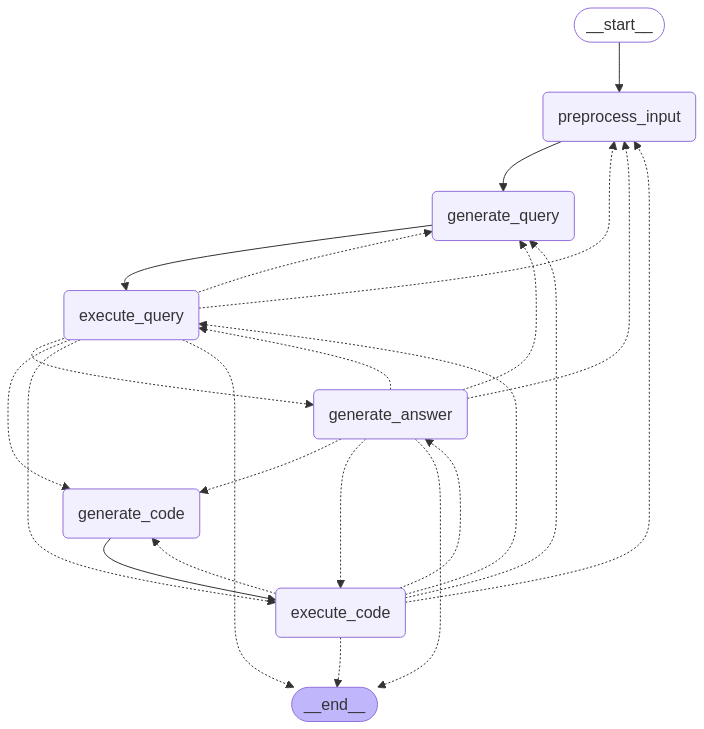

In [144]:
graph

In [182]:
graph.invoke({'question':'How many Invoices were there in 2009 and 2011? What are the respective total sales for each of those years?'})

{'question': [HumanMessage(content='How many Invoices were there in 2009 and 2011? What are the respective total sales for each of those years?', additional_kwargs={}, response_metadata={}, id='212d6423-963b-4739-9754-5c523e2a13d2')],
 'sql_task': 'Write a SQL query to count the number of invoices in the years 2009 and 2011 and to calculate the total sales for each of those years.',
 'vis_task': 'Create a bar chart to display the count of invoices and total sales for the years 2009 and 2011.',
 'query': "SELECT strftime('%Y', InvoiceDate) AS Year, COUNT(InvoiceId) AS InvoiceCount, SUM(Total) AS TotalSales\nFROM Invoice\nWHERE strftime('%Y', InvoiceDate) IN ('2009', '2011')\nGROUP BY Year\nORDER BY Year\nLIMIT 10;",
 'code': "import pandas as pd\nimport plotly.graph_objects as go\nimport plotly.offline as pyo\n\n# Load data\nfile_path = 'data.csv'\ndata = pd.read_csv(file_path)\n\n# Filter the data for the years 2009 and 2011\nfiltered_data = data[(data['Year'] == 2009) | (data['Year'] 

In [164]:
db.get_table_names()

C:\Users\navab\AppData\Local\Temp\ipykernel_21016\4073026401.py:1: LangChainDeprecationWarning:

The method `SQLDatabase.get_table_names` was deprecated in langchain-community 0.0.1 and will be removed in 1.0. Use :meth:`~get_usable_table_names` instead.



['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

In [183]:
db.run("""select count(i.invoiceid), sum(i.total)
from invoice as i
where i.invoicedate between datetime('2011-01-01 00:00:00') and datetime('2011-12-31 00:00:00');""")

'[(83, 469.58)]'

In [184]:
db.run("""
select count(i.invoiceid), sum(i.total)
from invoice as i
where i.invoicedate between datetime('2009-01-01 00:00:00') and datetime('2009-12-31 00:00:00');

""")

'[(83, 449.46)]'